<a href="https://colab.research.google.com/github/Karthick47v2/speech-emotion-classifier/blob/main/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio
! kaggle datasets download ejlok1/surrey-audiovisual-expressed-emotion-savee
! kaggle datasets download ejlok1/toronto-emotional-speech-set-tess

! unzip ravdess-emotional-speech-audio
! unzip surrey-audiovisual-expressed-emotion-savee
! unzip toronto-emotional-speech-set-tess

In [2]:
import glob
import pandas as pd
import numpy as np
import random
import librosa 
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
# 1 - neutral 
# 2 - calm ## 
# 3 - happy
# 4 - sad
# 5 - angry
# 6 - fear
# 7 - disgust 
# 8 - surprise

In [3]:
r_path_list = glob.glob('/content/Actor_*/**')
r_emotion_list = [int((x.split('.')[0]).split('-')[2]) for x in r_path_list]
r_df = pd.DataFrame({'path': r_path_list, 'emotion': r_emotion_list})

s_path_list = glob.glob('/content/ALL/**')
s_emotion_list = [(list((x.split('.')[0]).split('_')[1])[0]) + (list((x.split('.')[0]).split('_')[1])[1] if list((x.split('.')[0]).split('_')[1])[0] == 's' else '0') for x in s_path_list]
s_df = pd.DataFrame({'path': s_path_list, 'emotion': s_emotion_list})

t_path_list = glob.glob('/content/TESS Toronto emotional speech set data/**/**')
t_emotion_list = [((x.split('.')[0]).split('/')[-1].split('_')[-1]) for x in t_path_list]
t_df = pd.DataFrame({'path': t_path_list, 'emotion': t_emotion_list})

In [4]:
s_df['emotion'] = s_df['emotion'].replace(['a0', 'd0', 'f0', 'h0', 'n0', 'sa', 'su'], [5, 7, 6, 3, 1, 4, 8])
t_df['emotion'] = t_df['emotion'].replace(['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'], [5, 7, 6, 3, 1, 8, 4])

In [5]:
df = pd.concat([r_df, s_df, t_df], ignore_index=True)
df = df[df['emotion'] != 2]

In [6]:
df['emotion'].value_counts()

6    652
3    652
5    652
7    652
8    652
4    652
1    616
Name: emotion, dtype: int64

In [7]:
wav_len = []

for path in df['path']:
  y, sr = librosa.load(path, sr=None, mono=True)

  wav_len.append(y.shape[0] / sr)

df['length'] = wav_len

In [27]:
df.groupby(['emotion'])['length'].max()

emotion
1    6.156599
3    5.974830
4    7.138730
5    7.024830
6    5.911950
7    7.012585
8    6.289297
Name: length, dtype: float64

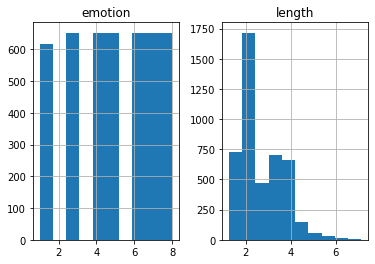

In [29]:
hist = df.hist()

TAKE 4s (4 * 22050 = 88200)

In [44]:
y, sr = librosa.load(df['path'][0], mono=True)

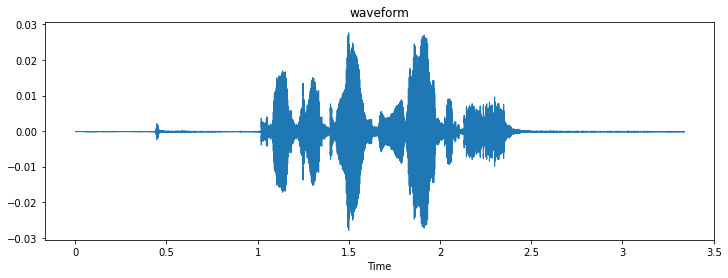

In [45]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr)
plt.title('waveform')
plt.show()

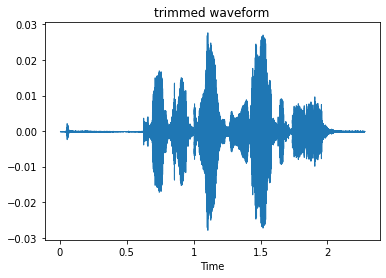

In [17]:
trimmed_y, idx = librosa.effects.trim(y, top_db=50) 
librosa.display.waveshow(trimmed_y, sr=sr)
plt.title('trimmed waveform')
plt.show()

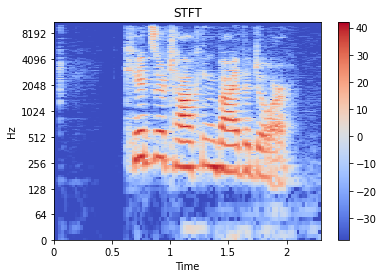

In [21]:
n_fft = 2048
hop_length = 512
# n_fft = 512
# hop_length = 128

# normalize
normalized_y = librosa.util.normalize(trimmed_y)
# short-term fourier transform
stft = librosa.core.stft(normalized_y, n_fft=n_fft, hop_length=hop_length)
# log scale
db = librosa.amplitude_to_db(abs(stft))

librosa.display.specshow(db, x_axis='time', y_axis='log')
plt.title('STFT')
plt.colorbar()
plt.show()

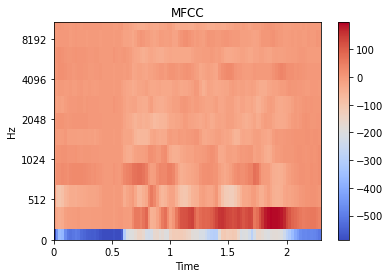

In [22]:
# mfcc
mfcc = librosa.feature.mfcc(normalized_y, sr, n_mfcc=13)

librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
plt.title('MFCC')
plt.colorbar()
plt.show()

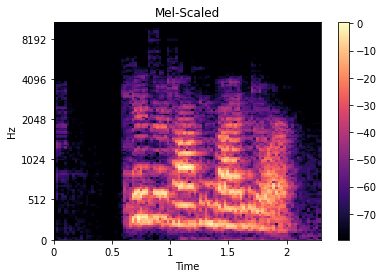

In [25]:
# mel scaled spectogram
mel = librosa.feature.melspectrogram(S=stft, n_mels=128)

mel_db = librosa.amplitude_to_db(abs(mel))
# mel_db = librosa.util.normalize(mel_db)

librosa.display.specshow(mel_db, x_axis='time', y_axis='mel')
plt.title('Mel-Scaled')
plt.colorbar()
plt.show()

In [ ]:
# feature extraction

In [57]:
def load_wav(path, stop):
  # 22.05 kHz, 16 bit
  y, sr = librosa.load(path, mono=True)
  trimmed_y, idx = librosa.effects.trim(y, top_db=50) 
  normalized_y = librosa.util.normalize(trimmed_y)
  y_chunks = [normalized_y[i:(i+stop)] for i in range(0, len(normalized_y), stop)]
  return y_chunks, sr

In [61]:
def extract_mfcc(y, sr, n_mfcc):
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
  normalized_mfcc = librosa.util.normalize(mfcc)

  return normalized_mfcc

def extract_mel(y, n_mel, n_fft, hop_length):
  stft = librosa.core.stft(y, n_fft=n_fft, hop_length=hop_length)

  mel = librosa.feature.melspectrogram(S=stft, n_mels=n_mel)
  mel_db = librosa.amplitude_to_db(abs(mel))
  normalized_mel = librosa.util.normalize(mel_db)

  return normalized_mel

In [64]:
# noise

def add_noise(y,s_noise, e_noise):
  noise = random.uniform(s_noise, e_noise)
  noised_y = y + np.random.rand(len(y)) * noise

  return noised_y

In [63]:
def add_padding(x, padding):
  padded_x = []

  for i in x:
    sh = len(i[0])

    if padding > 0 & sh < padding:
      x = padding - sh
      l_pad = x // 2
      r_pad = x - l_pad
      i = np.pad(i, pad_width=((0,0), (l_pad,r_pad)), mode='constant')

    padded_x.append(i)

  return padded_x

In [68]:
mfcc = []
mel = []
label = []
max_mfcc_frame = 0
max_mel_frame = 0

add_aug = True

for idx, row in df.iterrows():
  y_chunks, sr = load_wav(row['path'], 88200)

  for y in y_chunks:

    if len(y) > n_fft:

      ex_mfcc = extract_mfcc(y, sr, 13)
      ex_mel = extract_mel(y, 128, 2048, 512)

      mfcc.append(ex_mfcc)
      mel.append(ex_mel)
      label.append(row['emotion'])

      if add_aug:
        noised_y = add_noise(y, 0.005, 0.02)
          
        aug_mfcc = extract_mfcc(noised_y, sr, 13)
        aug_mel = extract_mel(noised_y, 128, 2048, 512)

        mfcc.append(aug_mfcc)
        mel.append(aug_mel)
        label.append(row['emotion'])

      if max_mfcc_frame < ex_mfcc.shape[1]:
        max_mfcc_frame = ex_mfcc.shape[1]

      if max_mel_frame < ex_mel.shape[1]:
        max_mel_frame = ex_mel.shape[1]

padded_mfcc = add_padding(mfcc, max_mfcc_frame)
padded_mel = add_padding(mel, max_mel_frame)

In [74]:
max_mel_frame

173

In [78]:
np.unique(label, return_counts=True)

(array([1, 3, 4, 5, 6, 7, 8]),
 array([1286, 1350, 1384, 1344, 1354, 1370, 1346]))

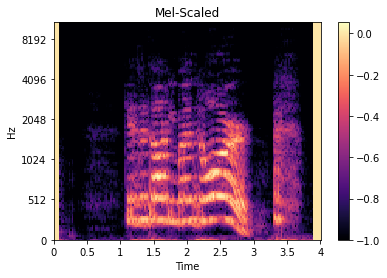

In [70]:
librosa.display.specshow(padded_mel[1000], x_axis='time', y_axis='mel')
plt.title('Mel-Scaled')
plt.colorbar()
plt.show()

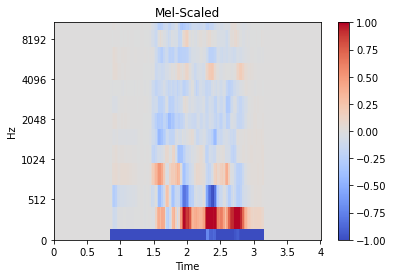

In [72]:
librosa.display.specshow(padded_mfcc[0], x_axis='time', y_axis='mel')
plt.title('Mel-Scaled')
plt.colorbar()
plt.show()

In [75]:
X_mfcc = np.array(padded_mfcc)
X_mel = np.array(padded_mel)
y = np.array(label)

np.save('X_mfcc', X_mfcc)
np.save('X_mel', X_mel)
np.save('y', y)

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
